/Users/sangyuxu/Data/MOTSangyu/dump/2018-07-30-GH146-Simultaneous-Green


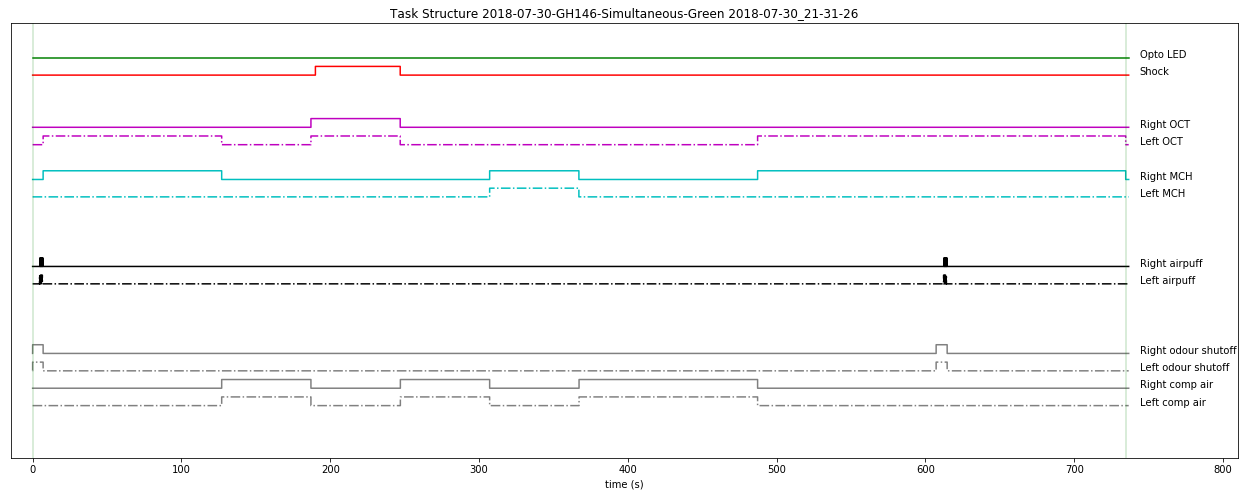

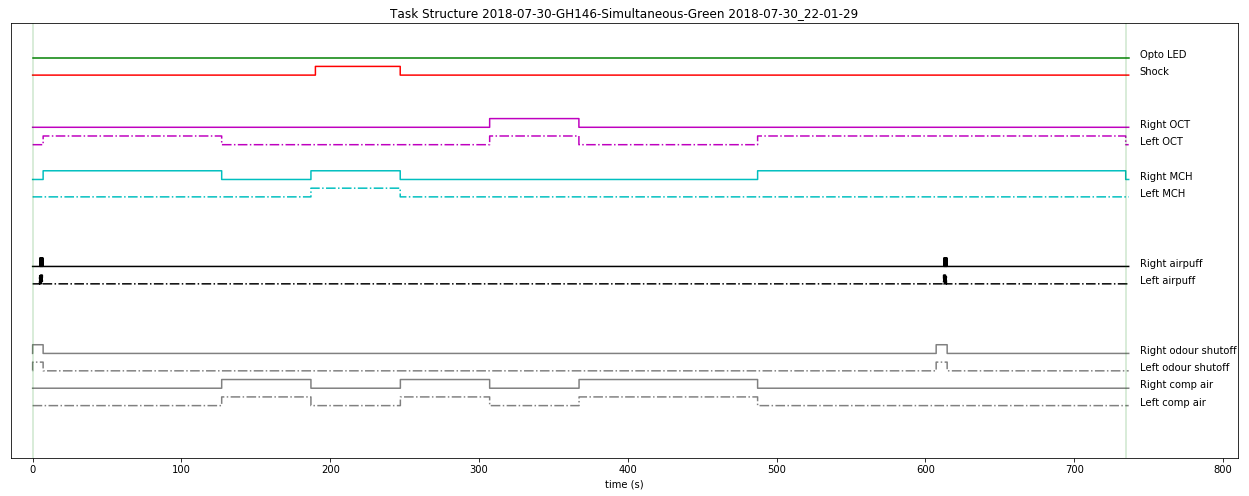

In [2]:
# this script eats one or more excecutionLog files and spits out pictures of the sequence run in the form of png files

import pandas as pd
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm as cm
import csv
import dabest
import seaborn as sns
%matplotlib inline
import os
currentPath = os.getcwd()

##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Change the direction of slashes in the section below~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# the following line finds the sample data folder in the same folder as the code
# datapath=currentPath+"/MOT2SampleData/2018-07-22-CS-Simultaneous-Green"
datapath=currentPath+"/MOT2SampleData/OK107Trace"

# or user can define the path to data folder with the following line
datapath="/Users/sangyuxu/Data/MOTSangyu/dump/2018-07-30-GH146-Simultaneous-Green"

experimentName=datapath.rsplit('/', 1)[-1]
if 1*("summary" in os.listdir(datapath))==0:
    os.mkdir(datapath + '/summary')
summaryFolderPath=datapath + '/summary/'
##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Change the direction of slashes in the section above~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


print (datapath)
filenames = os.listdir(datapath)
filenames.sort()
excecutions= [s for s in filenames if "ExecutionLog" in s]
for i in range(0, len(excecutions)):
    f = excecutions[i]
    dfExe = pd.read_csv(datapath+'/'+f, error_bad_lines=False)
    dfExe.columns = dfExe.columns.str.lower().str.replace(' ', '_')
    dfExe['step_completion_time']=pd.to_timedelta(dfExe['step_completion_time'])
    dfExe['step_completion_time']=dfExe['step_completion_time'].dt.total_seconds()
    dfExe['step_completion_time']=dfExe['step_completion_time']-dfExe.loc[1, 'step_completion_time']
    dfExe=dfExe.assign(step_initiation_time = dfExe['step_completion_time'])
    dfExe.step_initiation_time=dfExe.step_initiation_time.shift(1)
    dfExe.loc[1, 'step_initiation_time']=dfExe.loc[1, 'step_completion_time']
    dfExe=dfExe.assign(action = 1*(dfExe['action']=='ON')+1*(dfExe.action.str.contains('cX')))
    dfDOut=dfExe.loc[dfExe['step_type'] == 'Digital Output' ]
    dfFbS=dfExe.loc[dfExe['step_type'] == 'Feedback Stimulation' ]
    dfPlugin=dfExe.loc[dfExe['step_type'] == 'Plugin' ]
    dfAllOutput=pd.concat([dfDOut, dfFbS, dfPlugin])
    listOfDOutEvents=np.unique(dfAllOutput['attribute'])
    MCH = [s for s in listOfDOutEvents if "MCH" in s]
    OCT = [s for s in listOfDOutEvents if "OCT" in s]
    airpuff = [s for s in listOfDOutEvents if "airpuff" in s]
    odourshutoff = [s for s in listOfDOutEvents if "odour shutoff" in s]
    compair = [s for s in listOfDOutEvents if "comp air" in s]
    shock = [s for s in listOfDOutEvents if "Shock" in s]
    LED = [s for s in listOfDOutEvents if "Opto LED" in s]
    listOfDOutEvents=compair + odourshutoff + airpuff + OCT + MCH + shock + LED

    fig = plt.figure(figsize=(22,8))
    ax = fig.add_subplot(1, 1, 1)

    # for event in range(6,7):
    for event in range(0, len(listOfDOutEvents)):
        eventSegment=dfAllOutput.loc[dfAllOutput['attribute']==listOfDOutEvents[event]]
        eventSegment.index=range(1, len(eventSegment)+1)
        if 'LED' in listOfDOutEvents[event]:
            LEDOnOffIdx=eventSegment.loc[2:, 'step_initiation_time']
        eventSegment=eventSegment.append(eventSegment.loc[len(eventSegment)])
        eventSegment=eventSegment.append(eventSegment.loc[1])
        eventSegment=eventSegment.sort_values(by='step_initiation_time')
        eventSegment.index=range(1, len(eventSegment)+1)
        eventSegment.loc[1, 'action']=0
        eventSegment.loc[1, 'step_initiation_time']=0
        eventSegment.loc[len(eventSegment), 'action']=0
        eventSegment.loc[len(eventSegment), 'step_initiation_time']=dfExe["step_initiation_time"].iloc[-1]+0.001
        eventSegment.index=range(1, len(eventSegment)*2, 2)
        for slot in range(2, len(eventSegment)*2, 2):
            eventSegment.loc[slot]=eventSegment.loc[slot-1]
            eventSegment.loc[slot, 'step_initiation_time']=eventSegment.loc[slot+1, 'step_initiation_time']-0.002
        eventSegment=eventSegment.sort_values(by='step_initiation_time')
        maxX=max(eventSegment.step_initiation_time)
        if 'Left' in listOfDOutEvents[event]:
            linestyle='-.'
        if 'Right' in listOfDOutEvents[event]:
            linestyle='-'
        if 'MCH' in listOfDOutEvents[event]:
            color='c'
            offset=7
        elif 'OCT' in listOfDOutEvents[event]:
            color='m'
            offset=12
        elif 'Shock' in listOfDOutEvents[event]:        
            offset=12
            color='r'
        elif 'LED' in listOfDOutEvents[event]:
            offset=12
            color='g'
        elif 'puff' in listOfDOutEvents[event]:
            offset=6
            color='k'
        else:
            offset=3
            color='gray'
        plt.plot(eventSegment.step_initiation_time,offset+event+eventSegment.action/2, color, linestyle=linestyle)
        plt.text(np.max(eventSegment.step_initiation_time)*1.01,offset+event, listOfDOutEvents[event])
        plt.xlim([-maxX*0.02, maxX*1.1])
    plt.ylim([0, 25])
    plt.xlabel('time (s)')
    plt.title('Task Structure '+ experimentName + ' ' +f[13:-4] )
    ax.axes.get_yaxis().set_visible(False)

    for j in range (2, len(LEDOnOffIdx)+2):
        plt.plot([LEDOnOffIdx[j], LEDOnOffIdx[j]], [0, 25], 'g', alpha=0.2)
    plt.savefig(summaryFolderPath+ 'TaskStructure' + f[13:-4] + '.png', bbox_inches='tight', dpi = 300)
